# 02 - Prepare train-test split

Again, this notebook is for info only.  The developed data processing functions have been abstracted into the energy_forecast package, orchestrated by the `03_prepare_train_test.py` script.

You may prepare these files from the commandline using:
```bash
make preprocess_data
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import energy_forecast
from energy_forecast.loaders import load_ods, load_ods_sheetnames
from energy_forecast.transform import clean_energy_data, clean_temp_data, clean_wind_data
from energy_forecast.transform import clean_sun_data, clean_rain_data
from energy_forecast.utils import repo_root
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.detrend import STLTransformer
from statsmodels.graphics.tsaplots import month_plot, plot_acf
from pathlib import Path

In [3]:
REPO_ROOT = Path(repo_root())
DATA_INTERIM = REPO_ROOT / 'data' / 'interim'
DATA_FILE_PATH = DATA_INTERIM / 'transformed_energy_weather.csv'
DATA_PROCESSED = REPO_ROOT / "data" / "processed"

In [4]:
def load_and_set_types(path):
    df = (
        pd.read_csv(path)
        .assign(datetime=lambda x: pd.to_datetime(x['datetime'], format='%Y-%m-%d'))
        .set_index('datetime', drop=True)
    )
    return df

df = load_and_set_types(DATA_FILE_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 384 entries, 1991-01-01 to 2022-12-01
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_energy       330 non-null    float64
 1   coal               330 non-null    float64
 2   petroleum          330 non-null    float64
 3   natural gas        330 non-null    float64
 4   bioenergy & waste  330 non-null    float64
 5   elec_nuclear       330 non-null    float64
 6   elec_renewable     294 non-null    float64
 7   elec_import        306 non-null    float64
 8   temp               380 non-null    float64
 9   wind               260 non-null    float64
 10  sun                260 non-null    float64
 11  rain               260 non-null    float64
dtypes: float64(12)
memory usage: 39.0 KB


In [5]:
weather_cols = {
    'temp': 'degC',
    'wind': 'knots',
    'sun': 'hours',
    'rain': 'mm',
}
energy_cols = {
    'total_energy': 'mtoe', 
    'coal': 'mtoe', 
    'petroleum': 'mtoe', 
    'natural gas': 'mtoe', 
    'bioenergy & waste': 'mtoe', 
    'elec_nuclear': 'mtoe', 
    'elec_renewable': 'mtoe', 
    'elec_import': 'mtoe', 
}
combined_cols = dict(**energy_cols, **weather_cols)

## Check weather columns

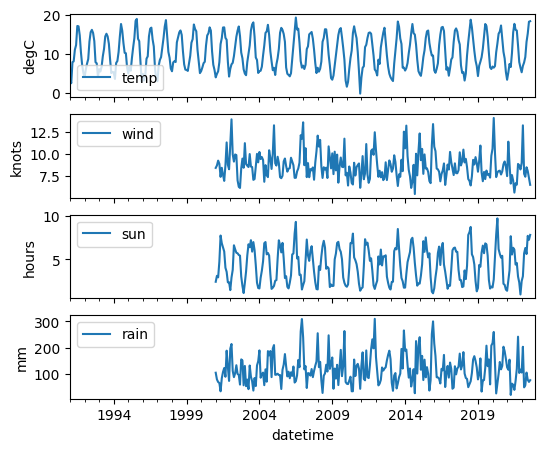

In [6]:
fig = plt.figure(figsize=(6,5))
for i, (col, unit) in enumerate(weather_cols.items()):
    sharex = ax if i>0 else None
    ax = fig.add_subplot(4,1,i+1, sharex=sharex)
    df.plot(y=col, color='C0', ax=ax)
    ax.set_ylabel(unit)

## Check energy columns

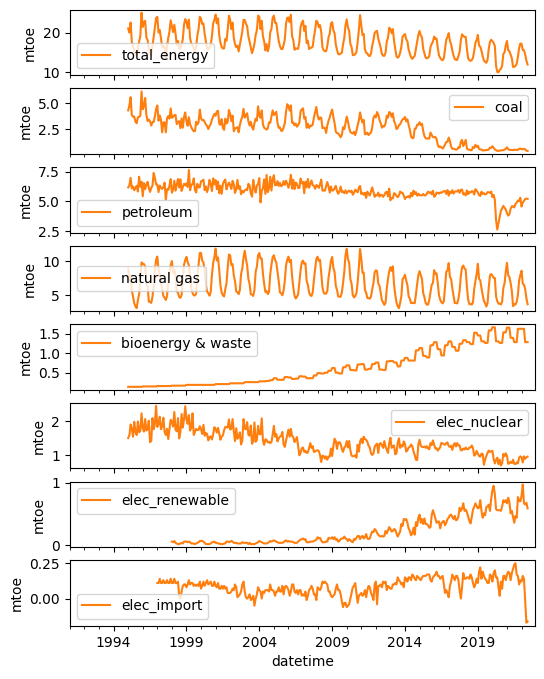

In [7]:
fig = plt.figure(figsize=(6,8))
for i, (col, unit) in enumerate(energy_cols.items()):
    sharex = ax if i>0 else None
    ax = fig.add_subplot(len(energy_cols),1,i+1, sharex=sharex)
    df.plot(y=col, color='C1', ax=ax)
    ax.set_ylabel(unit)
# fig.tight_layout()

## Deal with missing data

- Limited data prior to 2001-01.  We will drop rows prior to this
- Similarly, limited data after 2022-06. drop rows.
- We have complete data between these dates.

In [8]:
def crop_data(df: DataFrame) -> DataFrame:
    df = df.loc['2001-01-01':'2022-06-01']
    return df

df = crop_data(df)
df

,total_energy,coal,petroleum,natural gas,bioenergy & waste,elec_nuclear,elec_renewable,elec_import,temp,wind,sun,rain
datetime,,,,,,,,,,,,
2001-01-01,24.53,3.80,6.78,11.83,0.21,1.78,0.04,0.09,3.900000,8.425950,2.448102,103.481072
2001-02-01,22.30,4.21,6.01,10.08,0.21,1.67,0.04,0.08,4.800000,8.703050,3.125319,77.799117
2001-03-01,23.62,4.28,6.64,10.54,0.21,1.81,0.03,0.11,5.452066,9.246000,2.953300,67.968746
2001-04-01,19.31,3.01,5.67,8.67,0.21,1.65,0.03,0.07,7.806906,8.893600,4.744445,64.001636
2001-05-01,17.42,2.90,6.30,6.46,0.21,1.46,0.02,0.07,12.438507,7.419400,7.725524,32.301995
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,15.59,0.49,4.88,6.68,1.62,0.79,0.97,0.16,6.835289,13.218102,3.072332,202.980819
2022-03-01,15.49,0.54,5.01,6.54,1.62,0.97,0.67,0.14,7.717512,7.767567,5.684977,47.402353
2022-04-01,14.41,0.49,5.19,5.91,1.28,0.90,0.65,-0.01,9.134444,7.432602,6.303121,55.806545


# Split off Training and evaluation set


In [9]:
splits = temporal_train_test_split(df[['total_energy']], df[weather_cols.keys()], test_size=0.25)
y_train, y_test, x_train, x_test = splits
print([a.shape for a in [y_train, y_test, x_train, x_test]])

[(193, 1), (65, 1), (193, 4), (65, 4)]


In [10]:
# y_train.to_csv(DATA_PROCESSED / 'y_train.csv')
# y_test.to_csv(DATA_PROCESSED / 'y_test.csv')
# x_train.to_csv(DATA_PROCESSED / 'x_train.csv')
# x_test.to_csv(DATA_PROCESSED / 'x_test.csv')

# Forget about the test data, save it for later

In [11]:
y_train = load_and_set_types(DATA_PROCESSED / 'y_train.csv')
y_test = load_and_set_types(DATA_PROCESSED / 'y_test.csv')
x_train =load_and_set_types(DATA_PROCESSED / 'x_train.csv')
x_test = load_and_set_types(DATA_PROCESSED / 'x_test.csv')
print([a.shape for a in [y_train, y_test, x_train, x_test]])

[(193, 1), (65, 1), (193, 4), (65, 4)]


## STL decomp

In [12]:
stl = STLTransformer(sp=12, return_components=True)
decomposed = stl.fit_transform(y_train['total_energy'])
decomposed = pd.concat([y_train, decomposed], axis=1)

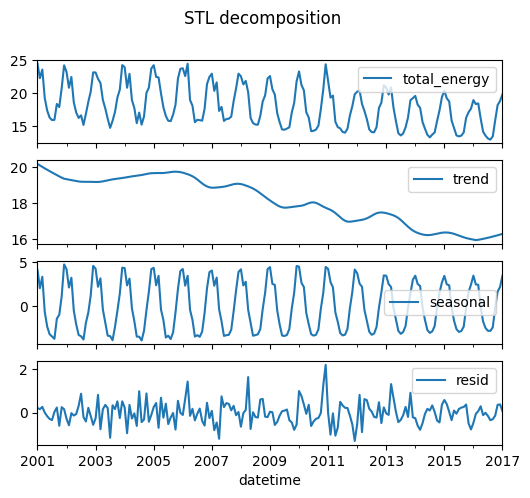

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6,5))
cols = ['total_energy', 'trend', 'seasonal', 'resid']

for ax, col in zip(axs, cols): 
    decomposed.plot(y=col, ax=ax)
fig.suptitle('STL decomposition');

## Timeseries Plots
Following along with https://otexts.com/fpp3/lag-plots.html

- Timeplot (pandas plot or matplotlib)
- Seasonal plot (seaborn lineplot with 'hue')
- Seasonal subseries monthly plot (statsmodels monthly_plot)


In [14]:
# Removed

This plot gives a good intuition of the general patterns. Looks like:
- Petroleum had a massive downward spike in the  last few years. This could be due to the pandemic's impact on road travel etc.
- Bioenergy and wind/solar etc are all on a steady rising trend, still small in proportion to total energy use though.
- There are some strong seasonal patterns in certain energy sources and,  as expected, in weather patterns.
- Coal especially has seen a sharp decline in use over the recent decade.


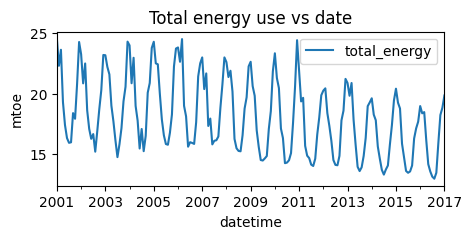

In [15]:
# Time plot for total energy use
fig, ax = plt.subplots(figsize=(5, 2))
y_train.plot(ax=ax)
ax.set_ylabel('mtoe');
ax.set_title('Total energy use vs date');

Zooming into just the total energy use **(which we will mostly be analysing and trying to forecast)**
- Trend is decreasing over time, not quite linearly.
- Looks like there is a strong yearly seasonality
- The amplitude of the seasonality component looks quite consistent.
- A reasonably sharp dip in mid-2020.  Could this coincide with Covid-19 related effects on energy use?

### Seasonal plot

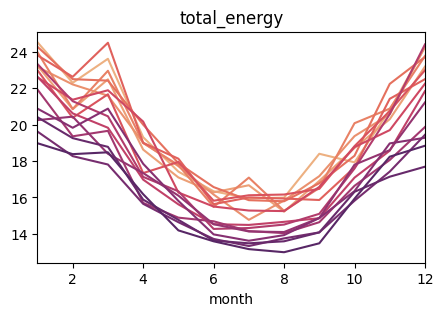

In [16]:
# Add year and month cols
y_train = (
    y_train
    .assign(year=lambda x: x.index.to_series().dt.year,
            month=lambda x: x.index.to_series().dt.month)
)

# Seasonal plot for energy consumption
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xticks(list(range(0,13,2)))
sns.lineplot(data=y_train, x='month', y='total_energy', 
             hue='year', ax=ax, palette='flare',
             legend=None)
ax.set_ylabel('')
ax.set_xlim([1,12])
ax.set_title('total_energy');


This grid of plots shows each season's data overlaid on an annual period.  Gives a quick intuition of the seasonal trends in the data
- Coal, natural gas all have quite a strong, similar seasonality effect.
- The seasonality in total energy use must be mostly due to the natural gas and coal seasonality.  These are probably driven by heating demand in winter months?
- Nuclear, petroleum etc are quite non-seasonal.

In [17]:
# # Plot seasonal for weather
# fig = plt.figure()
# fig.set_size_inches(12,3)
# for i, col in enumerate(['temp','wind','sun','rain']):
#     sharex = ax if i>0 else None
#     ax = fig.add_subplot(1,4,i+1, sharex=sharex)
#     sns.lineplot(data=df, x='month', y=col, hue='year', ax=ax, palette='crest' , legend=None)
#     ax.set_xlim([0,12])
#     ax.set_xticks(list(range(0,13,2)))
#     ax.set_ylabel('')
#     ax.set_title(col)
# fig.tight_layout()

# TODO - work on this vis

Likewise this plot grid shows the same thing, but for the weather data.
- Strong seasonality for Temps and daily Sunlight. Is inverse w.r.t. the total energy use seasonality we saw earlier.  Strong indication that UK energy use is driven by weather, and therefore heating demands.
- Wind speeds and rainfall have the opposite seasonality to Temp and daily Sunlight.
- These 4 charts basically confirm the expected seasonal weather patterns we see in this country.

### Seasonal subseries plot

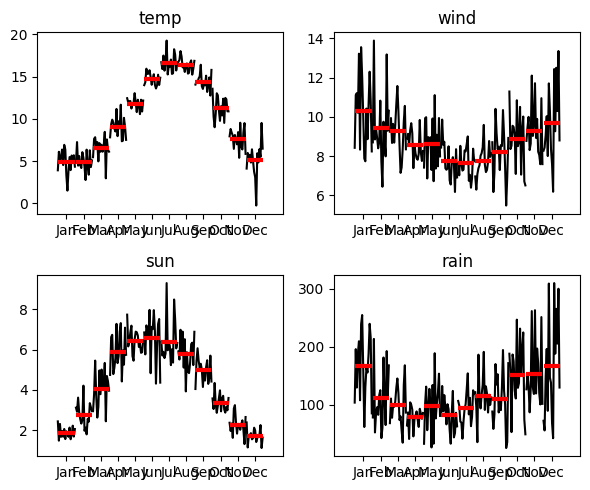

In [18]:
# Plot seasonal subseries plot for a few features
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 5))
axs = [ax for ax_row in axs for ax in ax_row]
cols = ['temp', 'wind', 'sun', 'rain']
for col, ax in zip(cols, axs):
    month_plot(x_train[col], ax=ax);
    ax.set_title(col)
    fig.tight_layout()

This seasonal subseries plot puts each month's data togather, so we can see the annual trend at each point in the year (seasonal period). by the shape of each line segment, rather than the colours on the previous seasonal grid plots.  

The mean value for each month is also plotted, so we can see the seasonal variation a bit more clearly.
- All columns shown have quite clear seasonality
- Total energy is highly seasonal (just like gas and coal use), but the decreasing trend is quite sharp in recent years and is quite consistent across all months.  We could conclude that the decreasing trend is more driven by decreases in other less seasonal energy sources like petroleum etc.
- We can see a strong rise in renewable energy use, though still small in proportion to other sources.

### Scatter matrix

In [19]:
# Scatter plot

# Doesn't really work yet we've not got any explanatory features really yet
# Might try once I have weather data included

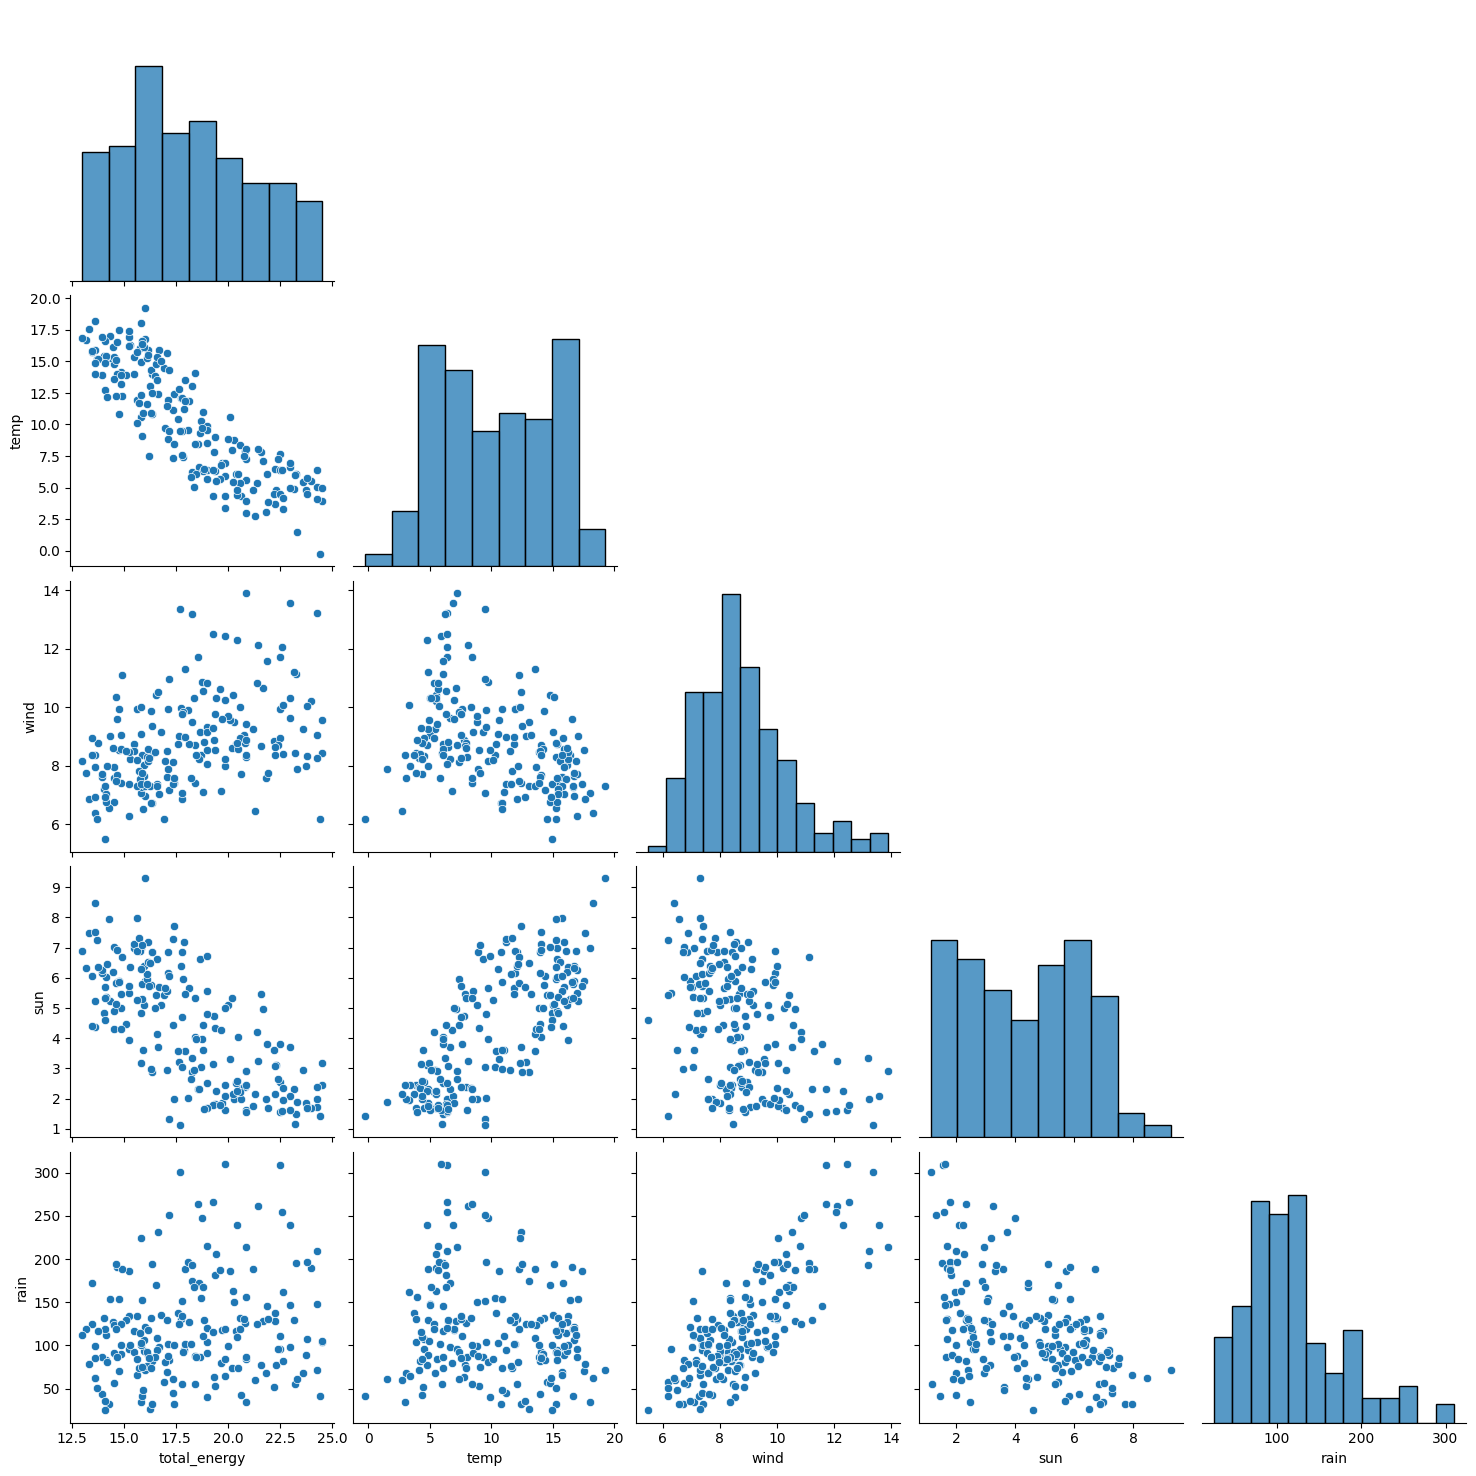

In [26]:
# Scatter matrix
# fig, ax = plt.subplots(figsize=(10, 10))
combined = pd.concat([y_train, x_train], axis=1).drop(columns=['year', 'month'])
sns.pairplot(combined, corner=True, height=3);

### Lag plot (TODO)

In [ ]:
# Lag plot
# TODO

### Autocorrelation plot

In [ ]:
# ACF plot
fig, ax = plt.subplots(figsize=(8,2))
plot_acf(y_train['total_energy'], ax=ax);

- Strong trough at 6 months, and peak at 12 months.  This is (unsurprisingly) showing us the 12-month seasonal period in the data.

### Correlation matrix (pearson)
We'll try this to establish correlation coefs for all available predictors.  Including weather fields

In [ ]:
import seaborn as sns
corr = combined.corr()
sns.heatmap(corr, square=True, annot=True, vmin=-1, vmax=1);

- Strong correlation with temperature and sunlight
- both temperature and sunlight are quote strongly correlated, could be multicollinearity problem?